<a href="https://colab.research.google.com/github/MathieuFan22/Mirada-Examen-ML-M2-ISPM/blob/Mendrika/PoketraFinday-Mirada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [24]:
import pandas as pd

# Affichage des données de test
test = pd.read_csv("test.csv")
print("Affichage des données de test :")
test.head(10)

Affichage des données de test :


,transaction_id,step,type,amount,customer_id,age
0,f9d47afa-6e9f-45a1-a443-afb5132e9986,494,PAYMENT,184500,C57389453,79
1,a3159433-df38-44d2-b6e1-3920b6f2a42f,322,PAYMENT,684000,C15998978,67
2,27b30f3c-7688-489f-9c77-d70981bf1a05,377,CASH_OUT,1344000,C48225516,22
3,c3566535-87b7-40d5-ac21-7874a193af11,592,PAYMENT,71100,C41411519,22
4,26ec3542-7f49-4252-b906-78157c647db8,450,CASH_OUT,13000,C37576173,53
5,263251d5-df93-4ee0-8beb-f392a062e777,659,CASH_OUT,2170600,C30619925,18
6,9c9eb6d7-ad99-48aa-b87b-8256b00bbfe2,605,PAYMENT,5000,C5433584,25
7,86a9f7cf-65fe-4d87-9f51-4bab9fdbabf7,16,TRANSFER,55500,C97422774,31
8,5d69da88-fff8-48a4-8bc4-74353aa077e0,104,DEBIT,43000,C43181007,20
9,5455bbc4-2c84-4ee6-9678-5c142d790f54,248,TRANSFER,25500,C46743764,65


In [25]:
# Affichage des données de train
train = pd.read_csv("train.csv")
print("Affichage des données de train :")
train.head(10)

Affichage des données de train :


,transaction_id,step,type,amount,customer_id,age,is_fraud
0,38d8cd1a-ab64-48a8-982b-547db096f8a5,421,PAYMENT,311000,C13646530,24,0
1,2440928e-8a4c-4e74-a9c5-6329668be13d,325,PAYMENT,399600,C9452763,25,0
2,973c2a3c-5676-477c-ac30-81334b01e90d,565,PAYMENT,7500,C31260354,38,0
3,5413d0f4-b4f0-406f-bd91-91de1dce573c,511,TRANSFER,94000,C8841991,26,0
4,c9fa99e2-42c8-4dd8-94ba-aa3e44bfdd98,63,CASH_OUT,15000,C3176716,26,0
5,fb3ef0a1-ce2e-4479-a621-f2267c2d697d,468,CASH_OUT,111800,C728995,20,0
6,f06bafef-fe08-4469-ac5b-c334698cf354,706,PAYMENT,37000,C12692187,29,0
7,5cdf85dc-32fe-49c3-a55c-fed0b2ef32d2,602,DEBIT,91500,C26312927,22,0
8,47c2812c-8507-42d0-b608-9c35e886a498,183,CASH_OUT,270000,C3105884,47,0
9,5bae90fc-a546-4b37-aa2b-52534340bb34,373,CASH_OUT,18500,C80405467,22,0


,count,fraud_rate (%)
type,,
TRANSFER,8160,6.458333
DEBIT,2974,0.672495
CASH_OUT,7716,0.272162
PAYMENT,11150,0.242152


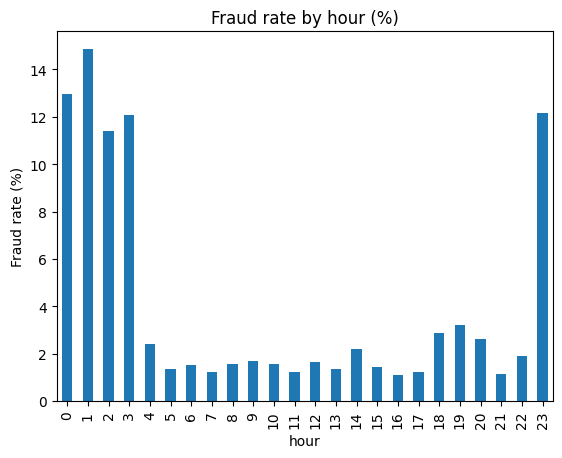

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Calcul du taux de fraude par type (en pourcentage)
fraud_stats = train.groupby('type')['is_fraud'].agg(['count','mean'])
fraud_stats['mean'] = fraud_stats['mean'] * 100  # convertir en %
fraud_stats.rename(columns={'mean': 'fraud_rate (%)'}, inplace=True)
fraud_stats = fraud_stats.sort_values('fraud_rate (%)', ascending=False)

# Afficher le tableau
display(fraud_stats)

# Log transform pour amount
train['log_amount'] = np.log1p(train['amount'])
test['log_amount']  = np.log1p(test['amount'])

# Extraire l'heure à partir du step
train['hour'] = ((train['step'] - 1) % 24).astype(int)

# Taux de fraude par heure
hourly = train.groupby('hour')['is_fraud'].mean() * 100  # en %
hourly.plot(kind='bar', title='Fraud rate by hour (%)')
plt.ylabel("Fraud rate (%)")
plt.show()

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# créer des catégories d'âge
train['age_group'] = pd.cut(train['age'], bins=[0,18,35,60,120], labels=[0,1,2,3]).astype(int)
test['age_group']  = pd.cut(test['age'], bins=[0,18,35,60,120], labels=[0,1,2,3]).astype(int)

# One-hot encoding sur 'type'
train = pd.get_dummies(train, columns=['type'], prefix='type')
test  = pd.get_dummies(test, columns=['type'], prefix='type')

# Nombre d'heures cumulées dans le mois peut être utilisé tel quel ou transformé
train['hour'] = ((train['step'] - 1) % 24).astype(int)
test['hour']  = ((test['step'] - 1) % 24).astype(int)

# Colonnes à utiliser pour le modèle
features = ['amount', 'log_amount', 'hour', 'age', 'age_group'] + \
           [c for c in train.columns if c.startswith('type_')]

X_train = train[features]
y_train = train['is_fraud']  # cible
X_test  = test[features]

# Split pour validation
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Entraîner le modèle
model = LogisticRegression(max_iter=1000, class_weight='balanced')  # balanced pour gérer le déséquilibre
model.fit(X_tr, y_tr)

# Prédictions sur validation
y_pred = model.predict(X_val)
print("F1-Score sur validation :", f1_score(y_val, y_pred))

submission = pd.DataFrame({
    "transaction_id": test["transaction_id"],
    "is_fraud": model.predict(X_test)
})
submission.to_csv("submission.csv", index=False)

F1-Score sur validation : 0.17871649065800163


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


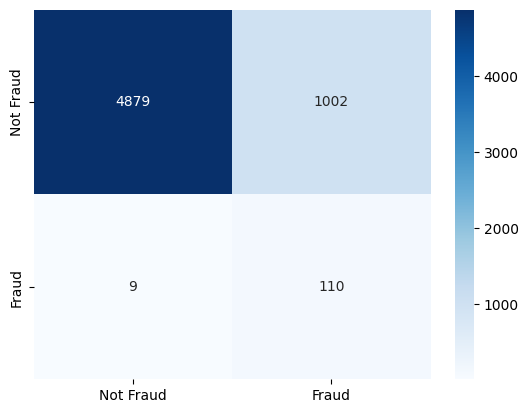

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Fraud','Fraud'], yticklabels=['Not Fraud','Fraud'])
plt.show()